In [2]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

In [3]:
customers = pd.read_csv("./data/Customers.csv")
transactions = pd.read_csv("./data/Transactions.csv")

data = transactions.merge(customers, on="CustomerID")

In [4]:
customer_features = data.groupby("CustomerID").agg({
    "TotalValue": "sum",        
    "TransactionID": "count",  
    "ProductID": "nunique",    
    "SignupDate": "first",     
    "Region": "first"          
}).rename(columns={
    "TotalValue": "TotalSpend",
    "TransactionID": "TransactionCount",
    "ProductID": "UniqueProducts"
})

customer_features["SignupDuration"] = (pd.Timestamp.now() - pd.to_datetime(customer_features["SignupDate"])).dt.days
customer_features.drop(columns=["SignupDate"], inplace=True)

In [5]:
customer_features = pd.get_dummies(customer_features, columns=["Region"], drop_first=True)

scaler = StandardScaler()
scaled_features = scaler.fit_transform(customer_features)

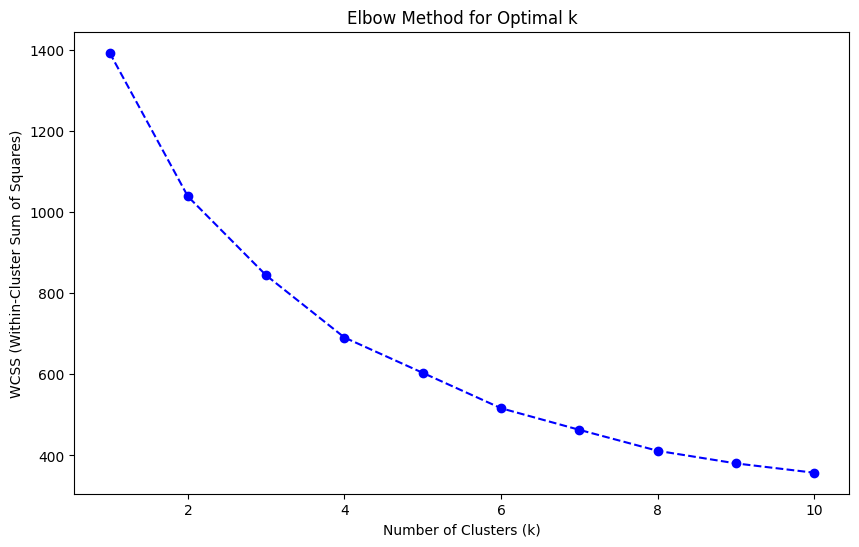

In [13]:
wcss = []

for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_features)
    wcss.append(kmeans.inertia_)


plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), wcss, marker='o', linestyle='--', color='b')
plt.title("Elbow Method for Optimal k")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("WCSS (Within-Cluster Sum of Squares)")
plt.show()

In [14]:
kmeans = KMeans(n_clusters=4, random_state=42)
clusters = kmeans.fit_predict(scaled_features)

print(clusters)
customer_features["Cluster"] = clusters


db_index = davies_bouldin_score(scaled_features, clusters)
print(f"Davies-Bouldin Index: {db_index}")

[1 3 1 1 3 1 3 0 2 2 1 1 1 2 3 3 0 3 2 3 0 0 2 0 1 3 3 0 3 3 1 3 3 0 3 3 2
 3 1 3 0 3 3 2 0 0 0 1 0 3 0 1 2 0 3 3 2 3 0 2 2 2 2 2 0 2 0 0 2 2 1 3 2 2
 0 1 3 3 3 3 2 1 1 0 1 2 1 3 2 0 1 3 0 3 3 1 3 0 1 2 0 1 2 1 2 3 1 1 0 3 2
 1 1 2 3 3 3 1 2 1 2 0 3 2 3 1 2 3 1 3 3 2 1 3 2 0 1 0 0 3 0 3 0 3 0 3 1 1
 2 3 3 1 1 0 1 0 3 1 3 3 0 0 1 2 1 2 2 1 1 2 1 2 0 1 0 3 3 3 2 1 2 3 1 3 3
 1 1 3 1 1 1 3 0 1 2 2 2 2 0]
Davies-Bouldin Index: 1.2594010106154223


In [15]:
pca = PCA(n_components=2)
pca_features = pca.fit_transform(scaled_features)

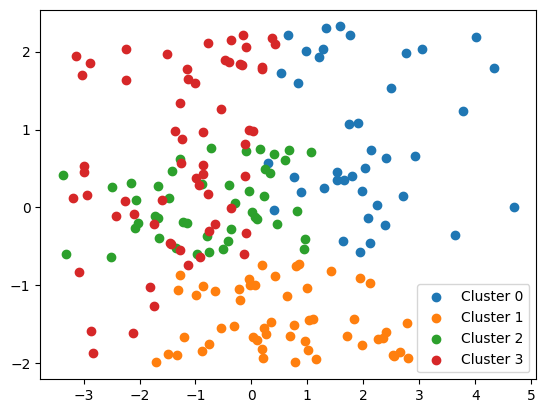

In [16]:
import numpy as np
u_labels = np.unique(clusters)

for i in u_labels:
    plt.scatter(pca_features[clusters == i, 0], pca_features[clusters == i, 1], label=f'Cluster {i}')

plt.legend()
plt.show()